<a href="https://www.kaggle.com/code/hydramst/water-pollution-linreg?scriptVersionId=98271117" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-pollution/water pollution (data for classification models)/Submission.csv
/kaggle/input/water-pollution/water pollution (data for classification models)/Target.csv
/kaggle/input/water-pollution/water pollution (data for classification models)/Train.csv
/kaggle/input/water-pollution/water pollution (data for classification models)/Test.csv
/kaggle/input/water-pollution/water_pollution_dataset/Submission.csv
/kaggle/input/water-pollution/water_pollution_dataset/Target.csv
/kaggle/input/water-pollution/water_pollution_dataset/Train.csv
/kaggle/input/water-pollution/water_pollution_dataset/Test.csv


In [66]:
DF_train = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Train.csv', delimiter = ',')
DF_test = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Test.csv', delimiter = ',')
Target = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Target.csv', delimiter = ',')
Submission = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Submission.csv', delimiter = ',')

In [67]:
Target

,Unnamed: 0,polution
0,6,0.013212
1,10,0.057482
2,17,0.037835
3,24,0.055119
4,34,0.037617
...,...,...
2313,19877,0.056002
2314,19890,0.105636
2315,19895,0.002696
2316,19899,0.087706


# Check if ID's in train presented in train

In [68]:
print('intersection of train and test ID\'s:', 
      len(set(DF_train['id'].values).intersection(set(DF_test['id'].values)))/len(set(DF_test['id'].values)))

intersection of train and test ID's: 0.6333333333333333


63% of test ID's presented in train

In [69]:
ids_intest = pd.DataFrame(DF_test['id'].values)
ids_intrain = pd.DataFrame(set(DF_train['id'].values).intersection(set(DF_test['id'].values)))

In [70]:
in_train = []
notin_train = []

for value in ids_intest.values:
    if (value in ids_intrain.values):
        in_train +=[value]
    else:
        notin_train +=[value]
        
id_notin_train = pd.DataFrame(notin_train, columns=['id'])
id_in_train = pd.DataFrame(in_train, columns=['id'])

print('ID presented in train:',len(in_train))

print( 'ID not presented in train:', len(notin_train))

ID presented in train: 78
ID not presented in train: 44


### Concatinate train and test

In [71]:
df = pd.concat([DF_train, DF_test])

In [72]:
df = df.drop(columns = ['Unnamed: 0'])

## View categorical and numerical columns

In [73]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))

categorical columns:	  ['code', 'period', 'id', 'Country'] 
 len =  4
numerical columns:	  ['year', 'tourists', 'venue', 'rate', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'leather', 'green_waste', 'waste_recycling'] 
 len =  13


## Move 'year' to num columns 

In [74]:
cat_columns = ['code', 'period', 'id', 'Country', 'year']
num_columns = [ 'tourists', 'venue', 'rate', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'leather', 'green_waste', 'waste_recycling'] 

### Fill NaN values with mean and ffill (for object) values

In [75]:
df_new = pd.concat([df, id_notin_train])

In [76]:
df_new[num_columns].fillna(df[num_columns].mean())
df_new = df.ffill()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2440 entries, 0 to 121
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code             2440 non-null   object 
 1   year             2440 non-null   int64  
 2   period           2440 non-null   object 
 3   id               2440 non-null   object 
 4   Country          2440 non-null   object 
 5   tourists         2440 non-null   float64
 6   venue            2440 non-null   float64
 7   rate             2440 non-null   float64
 8   food             2440 non-null   float64
 9   glass            2440 non-null   float64
 10  metal            2440 non-null   float64
 11  other            2440 non-null   float64
 12  paper            2440 non-null   float64
 13  plastic          2440 non-null   float64
 14  leather          2440 non-null   float64
 15  green_waste      2440 non-null   float64
 16  waste_recycling  2440 non-null   float64
dtypes: float64(12),

### Fill missing Target values with mean

In [77]:
mean_targ = Target['polution'].mean()
targ = []
for i in range(0, len(id_notin_train)):
    targ += [mean_targ]
    
#Target = pd.concat([Target, pd.DataFrame(targ, columns=['polution'])])

## OHE 

In [78]:
df_ohe = pd.get_dummies(df[cat_columns])
df_all = pd.concat([df_ohe, df[num_columns]], axis=1)

# Scaling

In [79]:
# Creating StandardScaler Object
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(df_all[num_columns]))
df_all = pd.concat([df_ohe.reset_index(drop=True), df_scale.reset_index(drop=True)], axis=1)

## Split back to test and train 


In [80]:
len_test = len(DF_test)
train = df_all.iloc[:-len_test]
test = df_all.iloc[-len_test:]
print(DF_train.shape[0], train.shape[0], DF_test.shape[0], test.shape[0])

2318 2318 122 122


# Log Scaling of Target

In [81]:
target_log = np.log(Target['polution'])
target_orig = Target['polution']

# Traintest split

In [82]:
X, y = pd.DataFrame(train).values, target_orig.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]

(1854, 464, 1854, 464)

In [83]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1854, 1562), (464, 1562), (1854,), (464,))

# GridSearchCV

In [84]:
### define model
model = Ridge()

alphas = np.array([1,0.1,0.01,0.001,0.0001,0.000001, 0.0000001])

# define parameters
param = {
    'alpha':alphas,
    'positive':[True, False],
    'copy_X':[True,False],
    'fit_intercept':[True,False]
    
}
#grid = GridSearchCV(model, param, scoring='r2', cv=2, n_jobs=-1)
#grid.fit(X_train, y_train)
#predictions = grid.predict(X_test)
#print('R2 : %.4f' %  r2_score(y_test,predictions))
#print('R2 : %.4f' % grid.best_score_)

# ElasticNetCV

In [85]:
model_ElasticCV = ElasticNetCV(n_alphas=1, fit_intercept=True, max_iter=100000, l1_ratio=0.9, eps=0.0001, cv=5)

#model_ElasticCV.fit(X_train, y_train)

#y_predict_ElasticCV = model_ElasticCV.predict(X_test)

#print('R2 : %.4f' %  r2_score(y_test,y_predict_ElasticCV))

# ElasticNet

In [86]:
model_Elastic = ElasticNet(alpha=0.005, fit_intercept=True, max_iter=100000, l1_ratio=0.1)

model_Elastic.fit(X_train, y_train)

y_predict_Elastic = model_Elastic.predict(X_test)

print('R2 : %.4f' %  r2_score(y_test,y_predict_Elastic))

R2 : 0.1254


# Ridge LR

In [87]:
model = Ridge(alpha = 0.1, fit_intercept=True, max_iter=10000)

model.fit(X_train, y_train)

y_predict=model.predict(X_test)

print('Error on test data:')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))

Error on test data:
MSE: 0.0
RMSE: 0.1
R2 : 0.4517


# Lasso

In [88]:
model_L = Lasso(alpha=0.00001, fit_intercept=True)

model_L.fit(X_train, y_train)
y_predict=model_L.predict(X_test)

print('R2 : %.4f' %  r2_score(y_test,y_predict))

R2 : 0.4415


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.336e-01, tolerance: 2.959e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## Compare answers with original values

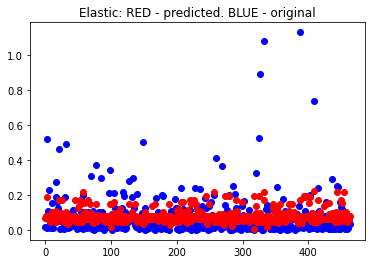

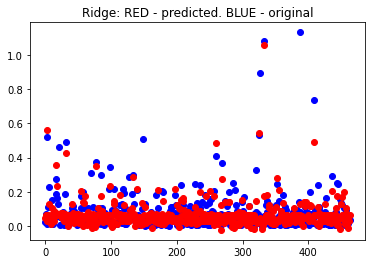

In [89]:
def plotGraph(y_test,y_predict,regressorName):
    if max(y_test) >= max(y_predict):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_predict))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_predict)), y_predict, color='red')
    plt.title(regressorName)
    plt.show()
    return


plotGraph(y_test, y_predict_Elastic, "Elastic: RED - predicted. BLUE - original")
plotGraph(y_test, y_predict, "Ridge: RED - predicted. BLUE - original")

# Cross validation

In [90]:
def cross_val(model, X_train, y_train):
  scoring = {'R2': 'r2',
            '-MSE': 'neg_mean_squared_error',
            '-MAE': 'neg_mean_absolute_error',
            'Max': 'max_error'}


  scores = cross_validate(model, X_train, y_train,
                        scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42) )

  print('CV Results')
  DF_cv_linreg = pd.DataFrame(scores)
  display(DF_cv_linreg)
  print('\n')
  print(DF_cv_linreg.mean()[2:])
  print('\n')

cross_val(model, X_train, y_train)

CV Results


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.304480,0.003226,0.106943,-0.008440,-0.049392,-0.545090
1,0.391010,0.003574,0.414898,-0.007877,-0.048745,-0.483716
2,0.302198,0.009229,0.464110,-0.004505,-0.044855,-0.241844
3,0.348468,0.003127,0.300172,-0.007735,-0.045030,-0.770208
4,0.319159,0.003263,0.399952,-0.006408,-0.044593,-0.486031




test_R2      0.337215
test_-MSE   -0.006993
test_-MAE   -0.046523
test_Max    -0.505378
dtype: float64




# Tests

### Export model

In [91]:
import pickle

In [108]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [93]:
! ls

Tests.py  __notebook_source__.ipynb  model.pkl	tests.py  water-pollution


In [94]:
import pytest

In [95]:
! rm /kaggle/working/water-pollution/Tests
! mkdir /kaggle/working/water-pollution/Tests
! touch /kaggle/working/water-pollution/Tests.py

rm: cannot remove '/kaggle/working/water-pollution/Tests': Is a directory
mkdir: cannot create directory ‘/kaggle/working/water-pollution/Tests’: File exists


In [123]:
%%writefile /kaggle/working/water-pollution/Tests.py

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import pickle


def test_data_preprocessing():
    DF_train = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Train.csv', delimiter = ',')
    DF_test = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Test.csv', delimiter = ',')
    Target = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Target.csv', delimiter = ',')
    Submission = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Submission.csv', delimiter = ',')
    
    
    df = pd.concat([DF_train, DF_test])
    
    cat_columns = ['code', 'period', 'id', 'Country', 'year']
    num_columns = [ 'tourists', 'venue', 'rate', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'leather', 'green_waste', 'waste_recycling'] 
    
    df_ohe = pd.get_dummies(df[cat_columns])
    df_all = pd.concat([df_ohe, df[num_columns]], axis=1)
    
    # Creating StandardScaler Object
    scaler = StandardScaler()
    df_scale = pd.DataFrame(scaler.fit_transform(df_all[num_columns]))
    df_all = pd.concat([df_ohe.reset_index(drop=True), df_scale.reset_index(drop=True)], axis=1)
    
    len_test = len(DF_test)
    train = df_all.iloc[:-len_test]
    test = df_all.iloc[-len_test:]
    target_orig = Target['polution']
    
    X, y = pd.DataFrame(train).values, target_orig.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    with open('model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    y_predict = loaded_model.predict(X_test)
    assert r2_score(y_test,y_predict) < 0.9
 

def test_model_2():
    DF_train = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Train.csv', delimiter = ',')
    DF_test = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Test.csv', delimiter = ',')
    Target = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Target.csv', delimiter = ',')
    Submission = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Submission.csv', delimiter = ',')
    
    
    df = pd.concat([DF_train, DF_test])
    
    cat_columns = ['code', 'period', 'id', 'Country', 'year']
    num_columns = [ 'tourists', 'venue', 'rate', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'leather', 'green_waste', 'waste_recycling'] 
   
    df_ohe = pd.get_dummies(df[cat_columns])
    df_all = pd.concat([df_ohe, df[num_columns]], axis=1)
    
    # Creating StandardScaler Object
    scaler = StandardScaler()
    df_scale = pd.DataFrame(scaler.fit_transform(df_all[num_columns]))
    df_all = pd.concat([df_ohe.reset_index(drop=True), df_scale.reset_index(drop=True)], axis=1)
    
    len_test = len(DF_test)
    train = df_all.iloc[:-len_test]
    test = df_all.iloc[-len_test:]
    target_orig = Target['polution']
    
    X, y = pd.DataFrame(train).values, target_orig.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)
    
    with open('model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    y_predict = loaded_model.predict(X_test)
    assert r2_score(y_test,y_predict) < 0.4 

Overwriting /kaggle/working/water-pollution/Tests.py


In [97]:
! cat /kaggle/working/water-pollution/Tests.py 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import pickle


def test_model_1():
    DF_train = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Train.csv', delimiter = ',')
    DF_test = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Test.csv', delimiter = ',')
    Targe

In [124]:
!pytest /kaggle/working/water-pollution/Tests.py

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /kaggle/working
plugins: typeguard-2.13.3, anyio-3.6.1
collected 2 items                                                              

water-pollution/Tests.py .F                                              [100%]

=================================== FAILURES ===================================
_________________________________ test_model_2 _________________________________

    def test_model_2():
        DF_train = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Train.csv', delimiter = ',')
        DF_test = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Test.csv', delimiter = ',')
        Target = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Target.csv', delimiter = ',')
        Submission = pd.read_csv('/kaggle/input/water-pollution/water_pollution_dataset/Submission.csv',

In [99]:
y_predict = model.predict(test)

# Convert back from log scaling
#y_predict = np.exp(y_predict)

Submission['polution'] = y_predict
Submission

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,idx,polution
0,402,0.085789
1,748,0.083067
2,763,0.090226
3,942,0.105130
4,1258,0.046907
...,...,...
117,19447,0.242635
118,19458,0.101256
119,19464,0.040332
120,19699,0.080940


In [100]:
! rm /kaggle/working/water-pollution/Submission.csv
! mkdir /kaggle/working/water-pollution/
Submission['polution'][27] = 2.0

mkdir: cannot create directory ‘/kaggle/working/water-pollution/’: File exists


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
Submission.to_csv('/kaggle/working/water-pollution/Submission.csv',index=False)

In [102]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json
! echo '{"username":"hydramst","key": "" }' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [103]:
cat ~/.kaggle/kaggle.json

{"username":"hydramst","key": "" }


In [104]:
#! kaggle competitions submit -f /kaggle/working/water-pollution/Submission.csv -m "Message" sf-matml-2022-regression